In [79]:
from importlib import reload
import numpy
import pandas as pd
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

from gradient import MyGDRegressor
from knn import CustomKNeighborsRegressor
from evaluation import evaluator
reload(evaluator)

<module 'evaluation.evaluator' from '/home/alex/code/ML/ML24/exercise-2/evaluation/evaluator.py'>

# Infrared Thermography Temperature

In [80]:
infrared_df = pd.read_csv("./infrared/FLIR_groups1and2.csv", header=None)
# Get actual header
infrared_headers = infrared_df.iloc[2]
# Remove Round header and measurements generic term
infrared_df = infrared_df[3:]
infrared_df.columns = infrared_headers

# Drop NaN columns and NaN rows
infrared_df = infrared_df.dropna(axis=1, how='all')
infrared_df = infrared_df.dropna()
# Remove all but one Round and insignificant columns
filtered_columns = [col for col in infrared_df.columns if
                    not col.endswith(('2', '3', '4')) and col not in ["Cosmetics", "Time", "Date", "SubjectID"]]
infrared_df = infrared_df[filtered_columns]

infrared_df = infrared_df.reset_index(drop=True)
infrared_df

2,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,...,T_OR1,T_OR_Max1,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance
0,0.17,34.92,35.09,34.53,34.67,34.93,34.92,34.89,34.96,35.08,...,34.13,34.16,36.85,36.64,Female,18-20,Asian,22.5,34.5,0.8
1,0.92,36.12,35.87,35.50,35.27,36.08,36.08,35.68,36.12,35.79,...,34.95,34.98,36.95,37.14,Female,18-20,Hispanic/Latino,23.4,27.3,0.8
2,0.82,35.05,35.05,33.72,34.29,35.14,35.06,35.14,35.15,35.06,...,34.40,34.41,36.65,36.59,Female,18-20,Asian,23.2,27.2,0.8
3,0.88,35.90,35.71,34.99,35.27,35.88,35.88,35.68,35.90,35.65,...,35.90,35.94,37.40,37.39,Male,21-25,White,23.1,27,0.8
4,0.63,34.99,34.43,34.61,33.72,34.97,34.97,34.87,34.99,34.57,...,35.25,35.28,36.65,36.49,Male,>60,Asian,22.8,33,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,1.15,36.05,36.08,35.17,35.28,36.05,36.04,36.04,36.05,36.11,...,36.12,36.13,36.95,36.99,Female,21-25,Hispanic/Latino,25.7,50.8,0.6
929,1.27,35.51,35.64,34.74,35.08,35.68,35.51,35.68,35.70,35.81,...,35.02,35.04,36.95,36.99,Female,21-25,Asian,25.7,50.8,0.6
930,1.45,35.98,35.84,35.35,35.16,35.97,35.97,35.88,36.01,35.84,...,36.58,36.60,37.25,37.19,Female,21-25,White,25.7,50.8,0.6
931,-0.07,36.36,36.25,35.67,35.76,36.34,36.34,36.31,36.36,36.18,...,35.53,35.57,37.35,37.59,Female,18-20,Black or African-American,28,24.3,0.6


In [81]:
print(infrared_df['Age'].unique())
print(infrared_df['Ethnicity'].unique())
print(infrared_df['Gender'].unique())

['18-20' '21-25' '>60' '26-30' '31-40' '51-60' '41-50' '21-30']
['Asian' 'Hispanic/Latino' 'White' 'Black or African-American'
 'Multiracial' 'American Indian or Alaskan Native']
['Female' 'Male']


In [82]:
infrared_df['Age'] = infrared_df['Age'].replace(['21-25', '26-30'], '21-30')
print(infrared_df['Age'].unique())

['18-20' '21-30' '>60' '31-40' '51-60' '41-50']


In [83]:
feature_mappings = {
    'Age': ['18-20', '21-30', '31-40', '41-50', '51-60', '>60']
}
ordinal_cols = ['Age']
one_hot_cols = ['Ethnicity', 'Gender']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = infrared_df.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_cols = numerical_cols.tolist()

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

ordinal_categories

[['18-20', '21-30', '31-40', '41-50', '51-60', '>60']]

In [84]:
infrared_df = infrared_df.drop('aveOralF',axis=1) # Set has two targets so drop one and chose the other
X = infrared_df.drop('aveOralM', axis=1) 
y = infrared_df[('aveOralM')] 

ir_X_train, ir_X_test, ir_y_train, ir_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
ir_X_train = pipeline.fit_transform(ir_X_train)
ir_X_test = pipeline.transform(ir_X_test)

ir_y_train = ir_y_train.to_numpy()
ir_y_test = ir_y_test.to_numpy()
ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)
ir_X_train

array([[2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.57142857e-01, 7.11462451e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.42857143e-01, 3.10276680e-01, 3.05888351e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.95238095e-01, 3.26086957e-01, 7.64720877e-04],
       ...,
       [2.00000000e-01, 0.00000000e+00, 1.00000000e+00, ...,
        3.69047619e-01, 1.56126482e-01, 7.64720877e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.14285714e-01, 2.13438735e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.52380952e-01, 3.16205534e-01, 3.18633699e-03]])

# Black Friday

In [86]:
data, meta = arff.loadarff("./black_friday.arff")
black_df = pd.DataFrame(data)

for column in black_df.columns:
    # replace missing values with pd.NA
    black_df[column] = black_df[column].replace(b'?', pd.NA)
    black_df[column] = black_df[column].replace(b'', pd.NA)
    black_df[column] = black_df[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    black_df[column] = black_df[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
black_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10.0,A,2,0.0,1.0,6.0,14.0,15200.0
1,M,46-50,7.0,B,2,1.0,1.0,8.0,17.0,19215.0
2,M,26-35,20.0,A,1,1.0,1.0,2.0,5.0,15665.0
3,F,51-55,9.0,A,1,0.0,5.0,8.0,14.0,5378.0
4,F,51-55,9.0,A,1,0.0,2.0,3.0,4.0,13055.0
...,...,...,...,...,...,...,...,...,...,...
166816,F,46-50,0.0,B,4+,1.0,3.0,4.0,12.0,8047.0
166817,M,26-35,6.0,B,2,0.0,6.0,8.0,14.0,16493.0
166818,M,26-35,6.0,B,2,0.0,2.0,3.0,10.0,3425.0
166819,M,26-35,6.0,B,2,0.0,1.0,2.0,15.0,15694.0


In [87]:
y = black_df[('Purchase')] 
X = black_df.drop('Purchase', axis=1)  # Features

bf_X_train, bf_X_test, bf_y_train, bf_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
print(black_df['Age'].unique())

['0-17' '46-50' '26-35' '51-55' '36-45' '18-25' '55+']


In [89]:
feature_mappings = {
    'Age': ['0-17','18-25','26-35', '36-45', '46-50', '51-55', '55+']
}
ordinal_cols = ['Age']
one_hot_cols = ['City_Category', 'Gender', 'Stay_In_Current_City_Years']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = [col for col in black_df.select_dtypes(include="number").columns if col != 'Purchase']

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])



In [90]:

bf_X_train = pipeline.fit_transform(bf_X_train)
bf_X_test = pipeline.transform(bf_X_test)
bf_y_train = bf_y_train.to_numpy()
bf_y_test = bf_y_test.to_numpy()
bf_X_train

array([[0.33333333, 1.        , 0.        , ..., 0.5       , 0.85714286,
        0.86666667],
       [0.33333333, 1.        , 0.        , ..., 0.85714286, 0.92857143,
        0.86666667],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       ...,
       [0.16666667, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       [0.5       , 1.        , 0.        , ..., 0.07142857, 0.14285714,
        0.13333333],
       [0.66666667, 0.        , 1.        , ..., 0.        , 0.        ,
        0.13333333]])

# Power plant

In [91]:
ccpp_df = pd.read_excel("./CCPP/Folds5x2_pp.xlsx")
ccpp_df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [92]:
X = ccpp_df.drop('PE', axis=1)
y = ccpp_df.PE
# Split for training
ccpp_X_train, ccpp_X_test, ccpp_y_train, ccpp_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
cols_to_scale = remaining_columns = [col for col in ccpp_df.columns if col != "PE"]
preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), cols_to_scale)],
    remainder='passthrough')

ccpp_X_train = preprocessor.fit_transform(ccpp_X_train)
ccpp_X_test = preprocessor.transform(ccpp_X_test)
ccpp_y_train = ccpp_y_train.to_numpy()
ccpp_y_test = ccpp_y_test.to_numpy()
ccpp_X_train

array([[0.59585185, 0.42099644, 0.40584014, 0.84294611],
       [0.27496296, 0.26814947, 0.80623608, 0.65894936],
       [0.19792593, 0.25355872, 0.69685721, 0.83184403],
       ...,
       [0.76977778, 0.78060498, 0.49418461, 0.26279448],
       [0.30962963, 0.28718861, 0.54392477, 0.85445437],
       [0.29451852, 0.2702847 , 0.62360802, 0.96669374]])

## knn evaluation

In [94]:
### neighbors

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 30}
Hyperparameter  n_neighbors  value:  1
R2:  0.9385833229321203
MSE:  17.814397283176586
Hyperparameter  n_neighbors  value:  2
R2:  0.9478269660069413
MSE:  15.133204845872521
Hyperparameter  n_neighbors  value:  3
R2:  0.9523652741949353
MSE:  13.81683234064786
Hyperparameter  n_neighbors  value:  5
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  n_neighbors  value:  10
R2:  0.9516905102143829
MSE:  14.012553017763844
Hyperparameter  n_neighbors  value:  15
R2:  0.9508051054094232
MSE:  14.269371746894237
Hyperparameter  n_neighbors  value:  20
R2:  0.9496374228668746
MSE:  14.608067386363627


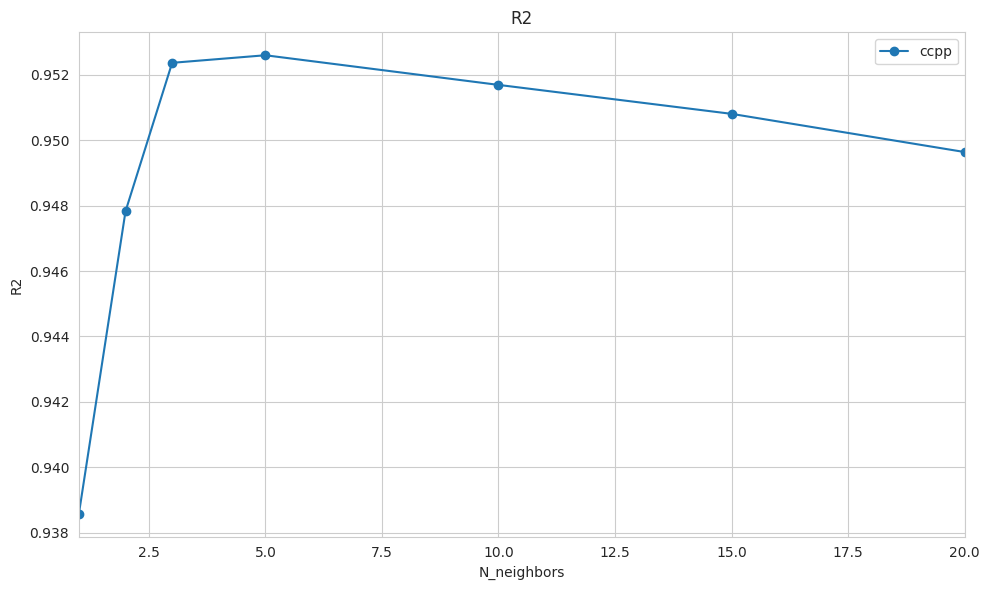

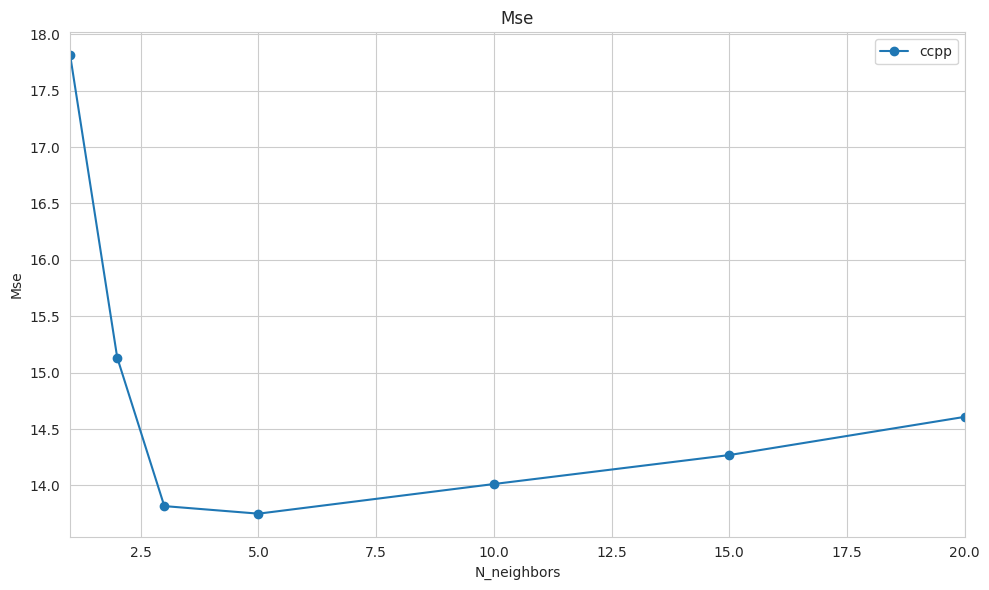

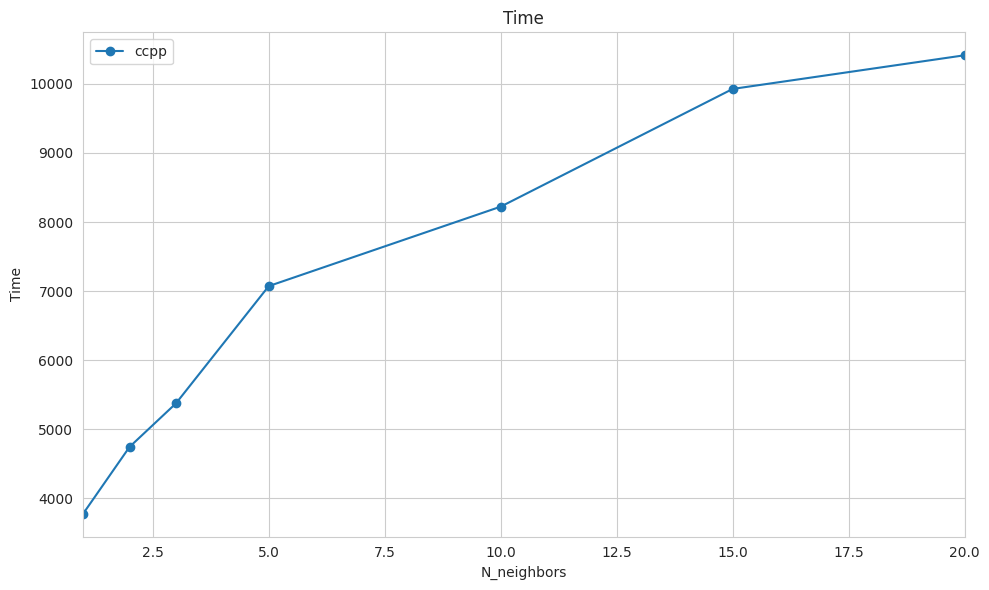

In [95]:
hyperparameters = {
    #'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'n_neighbors': [1, 2, 3, 5, 10, 15, 20]}
knn_neigh_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_neigh_ccpp}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

Evaluating Model:  KNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'metric': 'minkowski'}
Hyperparameter  n_neighbors  value:  1
R2:  -0.018217515303123877
MSE:  26499560.885089166
Hyperparameter  n_neighbors  value:  10
R2:  0.30501844553577173
MSE:  18087202.13485629
Hyperparameter  n_neighbors  value:  20
R2:  0.2930888804258883
MSE:  18397674.339675784


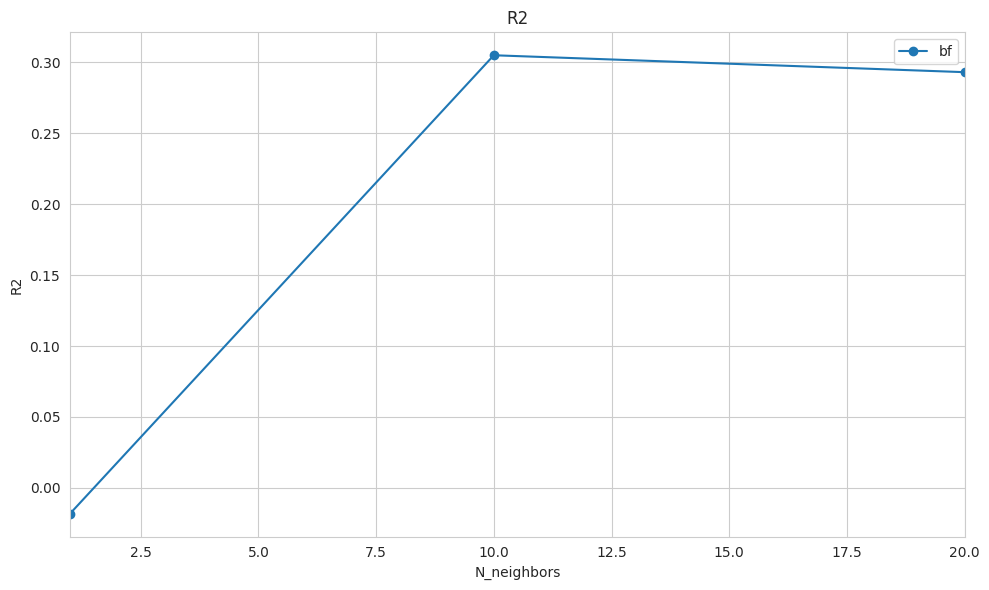

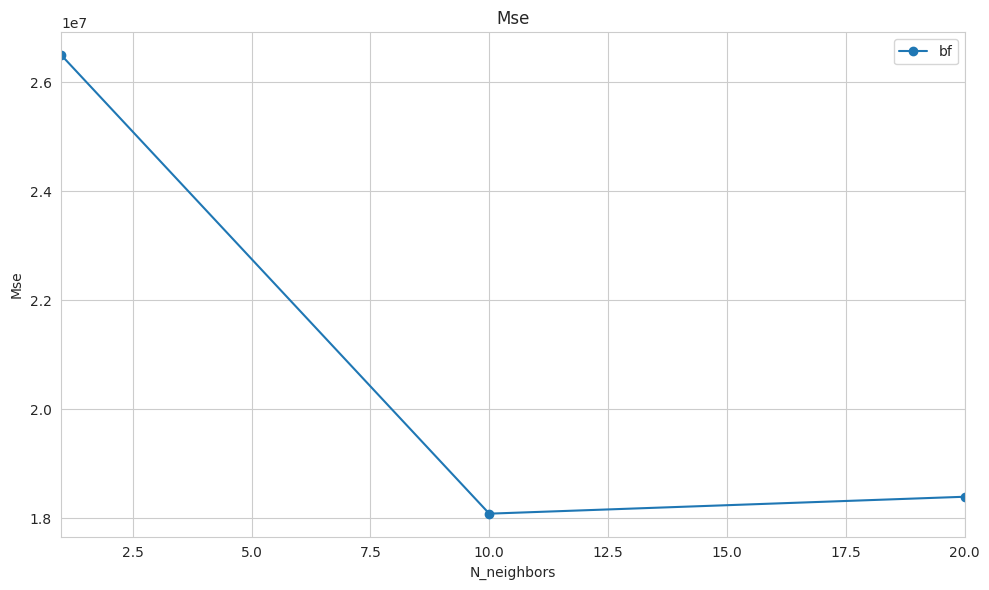

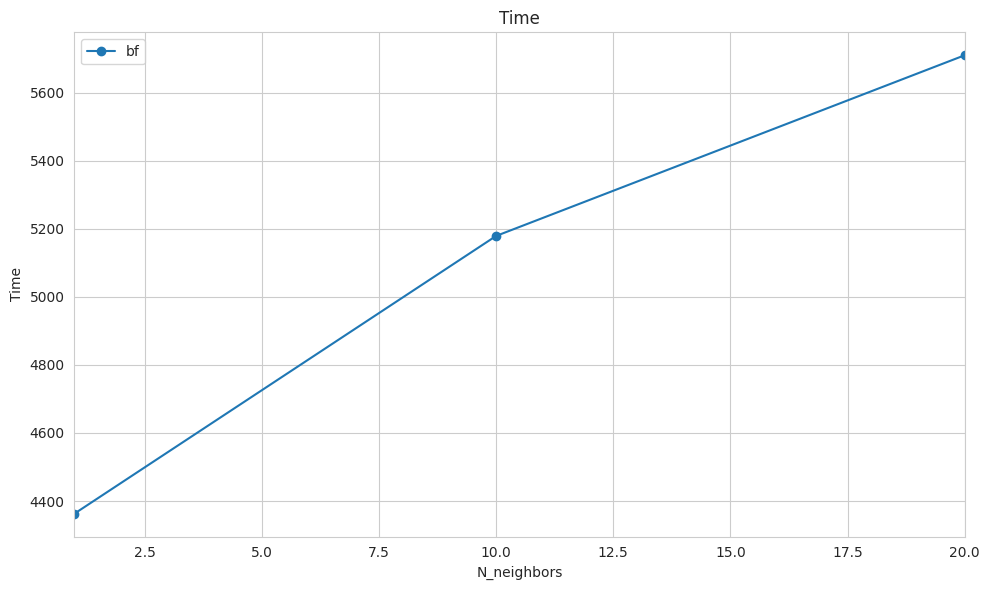

In [109]:
# to slow !!!!
hyperparameters_iterator = {'n_neighbors': [1, 10, 20]}
from sklearn.neighbors import KNeighborsRegressor
knn_neigh_bf = evaluator.evaluate2(KNeighborsRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"bf": knn_neigh_bf}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 30}
Hyperparameter  n_neighbors  value:  1
R2:  0.2841650154493204
MSE:  0.14830213903743317
Hyperparameter  n_neighbors  value:  2
R2:  0.3946248130518283
MSE:  0.12541778074866322
Hyperparameter  n_neighbors  value:  3
R2:  0.4127094388897735
MSE:  0.12167112299465255
Hyperparameter  n_neighbors  value:  5
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  n_neighbors  value:  10
R2:  0.46785706151638706
MSE:  0.11024598930481272
Hyperparameter  n_neighbors  value:  15
R2:  0.4273168118810057
MSE:  0.11864486036838942
Hyperparameter  n_neighbors  value:  20
R2:  0.413225520228364
MSE:  0.12156420454545394


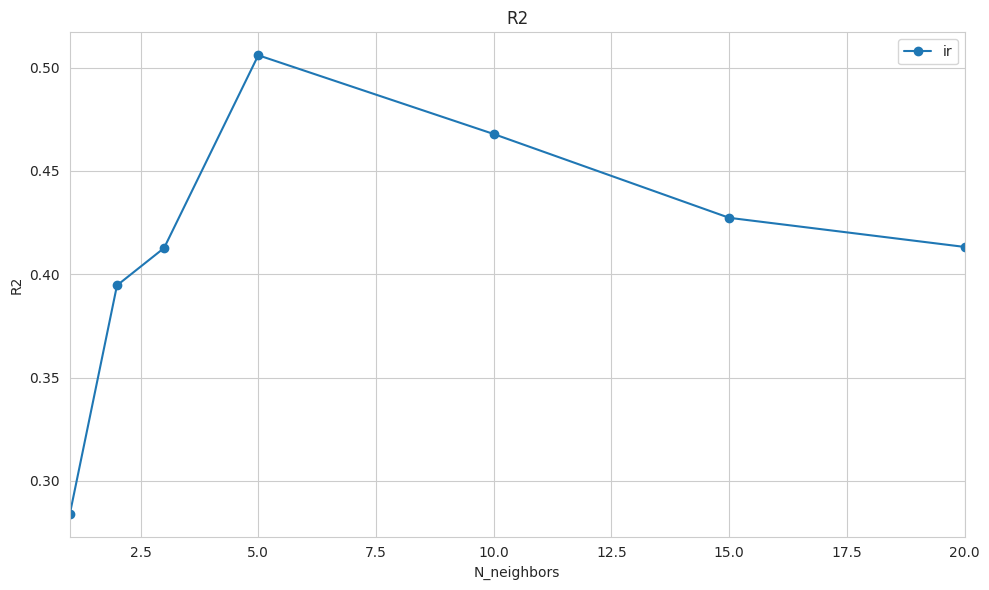

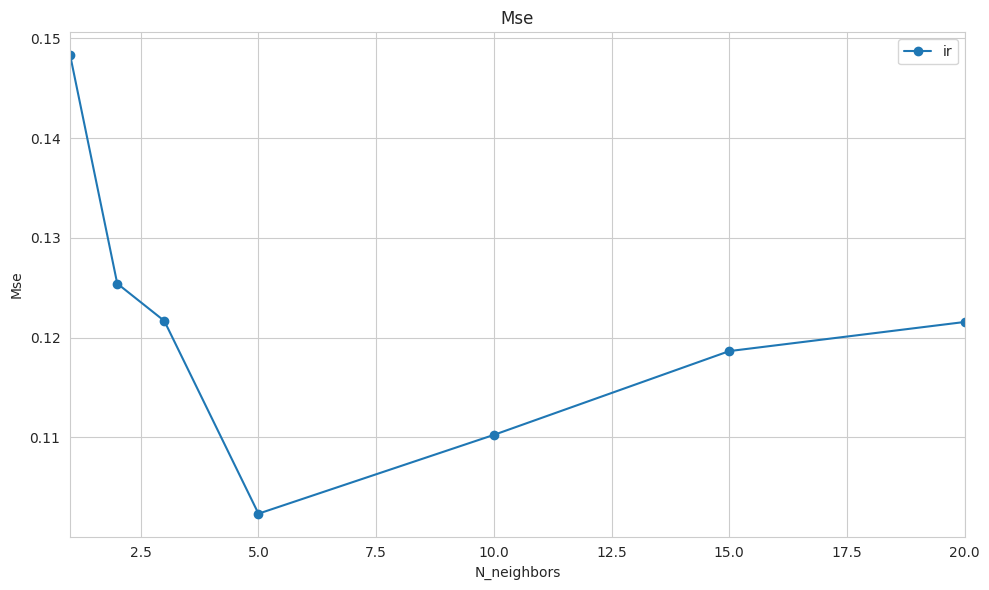

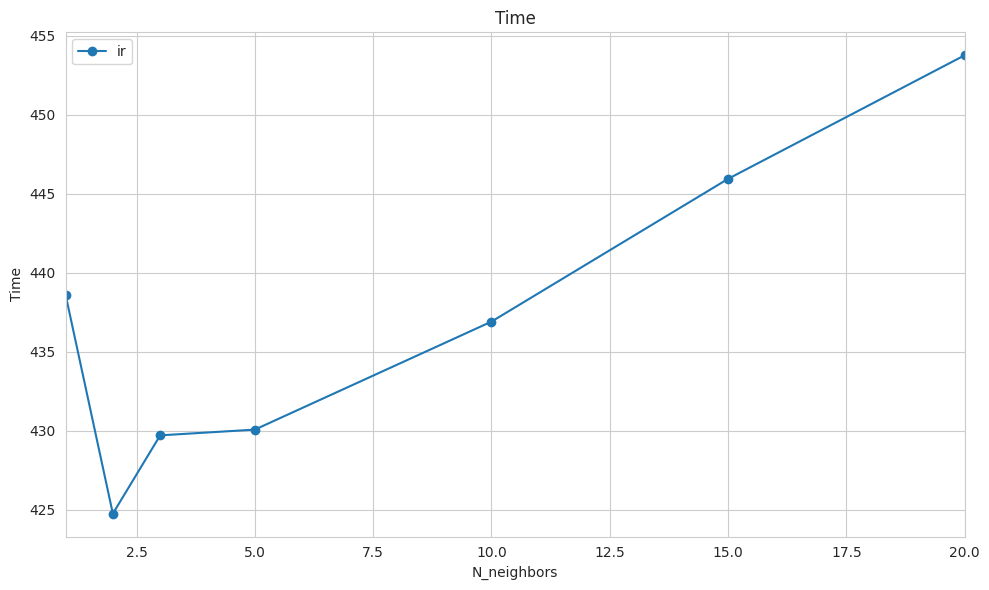

In [97]:
hyperparameters_iterator = {'n_neighbors': [1, 2, 3, 5, 10, 15, 20]}
knn_neigh_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test, hyperparameters=hyperparameters,    
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_neigh_ir}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

### metric

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30}
Hyperparameter  metric  value:  euclidean
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  metric  value:  minkowski
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  metric  value:  cosine
R2:  0.9333808755607642
MSE:  19.323408658307212
Hyperparameter  metric  value:  cityblock
R2:  0.9565464677922075
MSE:  12.60404377220482


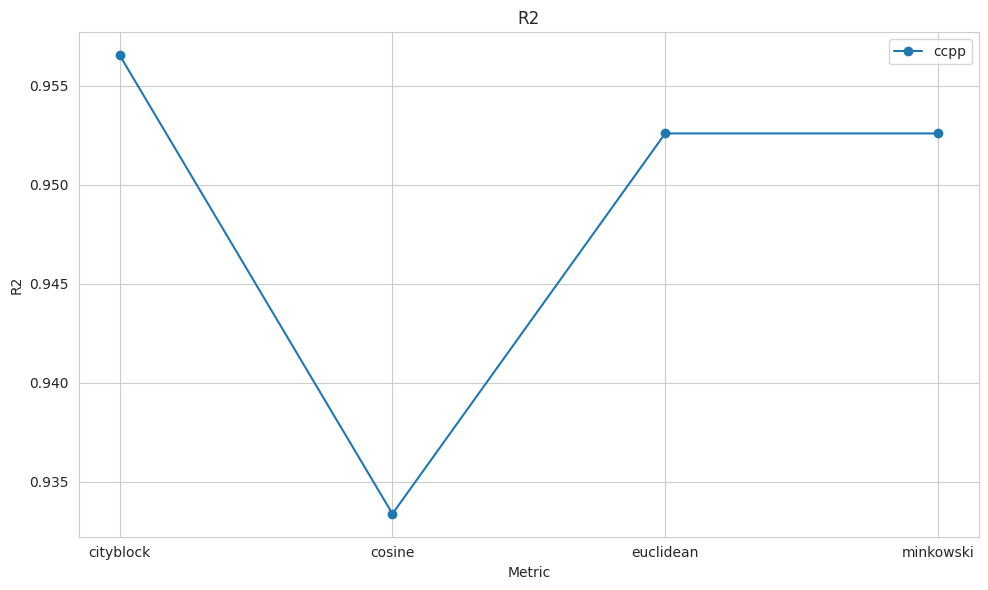

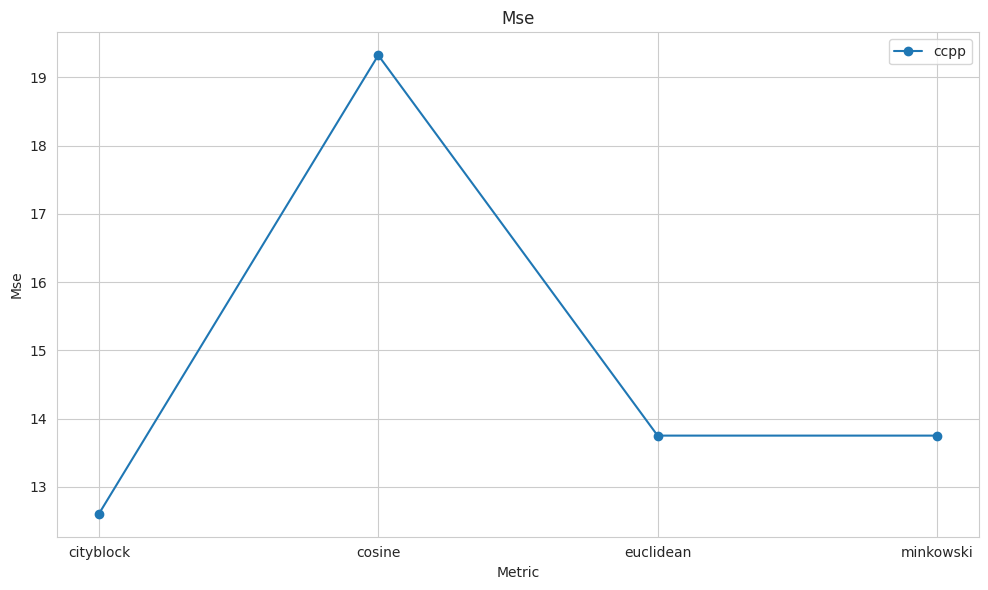

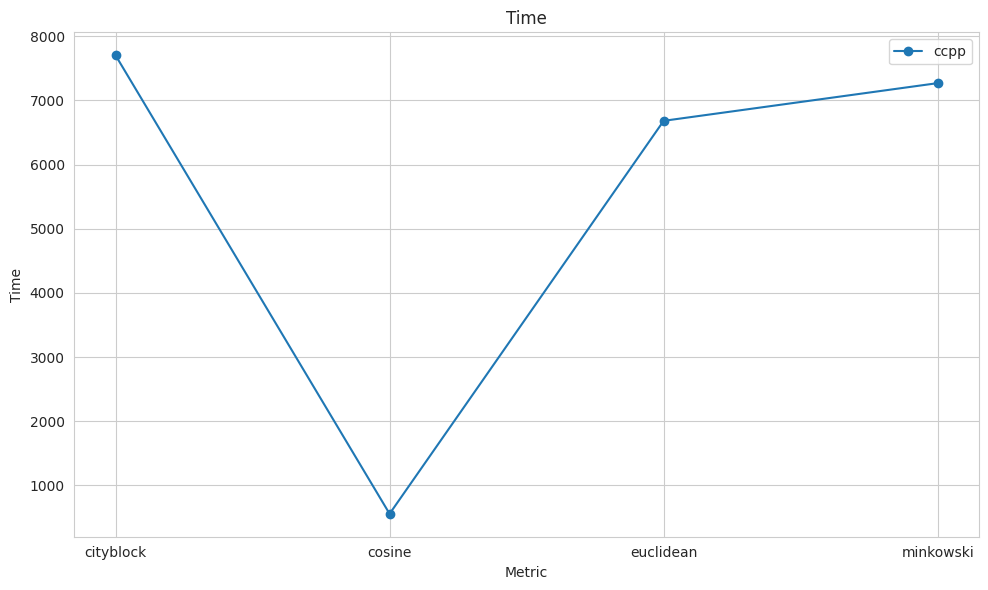

In [98]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    #'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'metric': ['euclidean', 'minkowski', 'cosine', 'cityblock']}
knn_metric_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_metric_ccpp}, x_axis='metric', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30}
Hyperparameter  metric  value:  euclidean
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  metric  value:  minkowski
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  metric  value:  cosine
R2:  0.2505989174087654
MSE:  0.15525614973262022
Hyperparameter  metric  value:  cityblock
R2:  0.5471648408378315
MSE:  0.09381550802139031


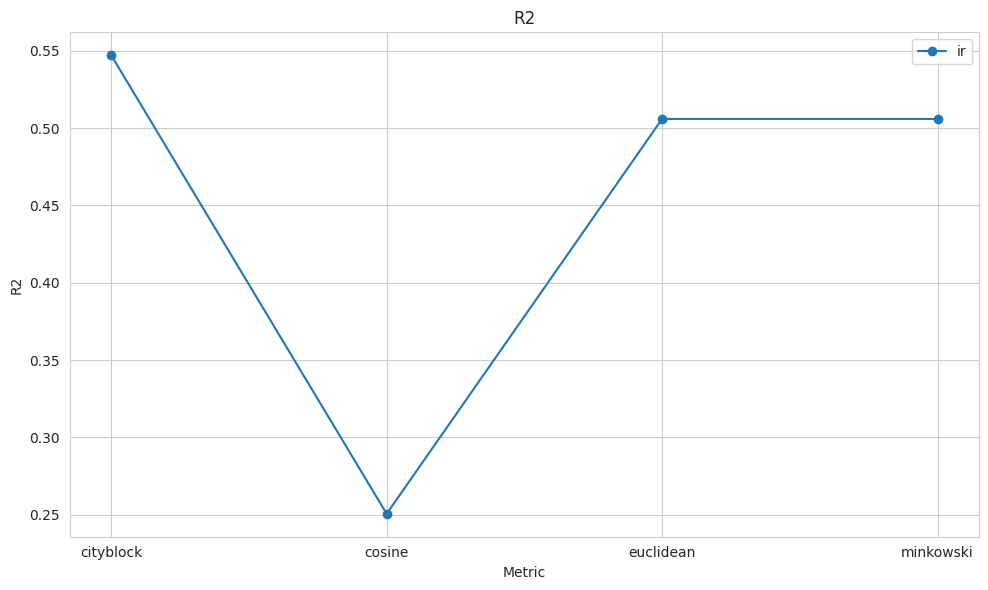

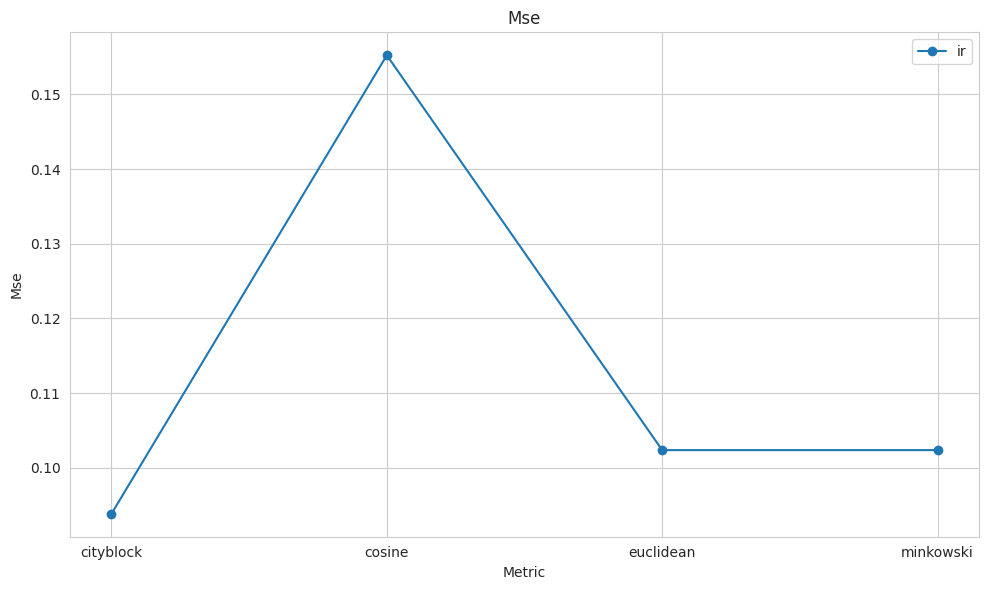

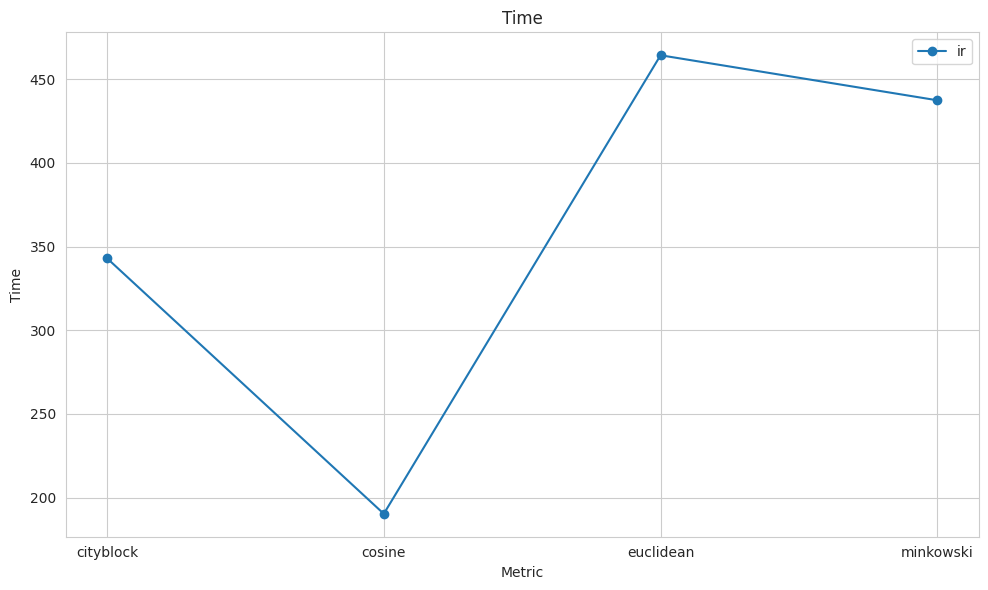

In [99]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    #'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'metric': ['euclidean', 'minkowski', 'cosine', 'cityblock']}
knn_metric_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_metric_ir}, x_axis='metric', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

### leaf size

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'metric': 'minkowski'}
Hyperparameter  leaf_size  value:  1
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  10
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  100
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  200
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  500
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  1000
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  5000
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  leaf_size  value:  10000
R2:  0.5059790010704448
MSE:  0.10234812834224584


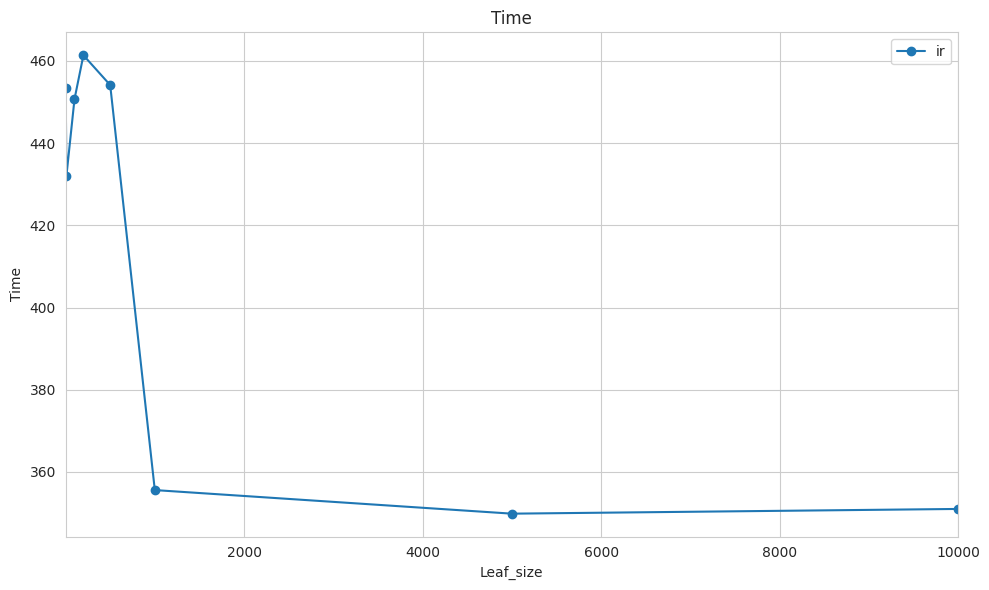

In [100]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    #'leaf_size': 30
}
hyperparameters_iterator = {'leaf_size': [1, 10, 100, 200, 500, 1000, 5000, 10000]}
knn_leaf_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_leaf_ir}, x_axis='leaf_size', y_axis=['time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'metric': 'minkowski'}
Hyperparameter  leaf_size  value:  1
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  10
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  100
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  200
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  500
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  1000
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  leaf_size  value:  5000
R2:  0.952596495260365
MSE:  13.749764825496353


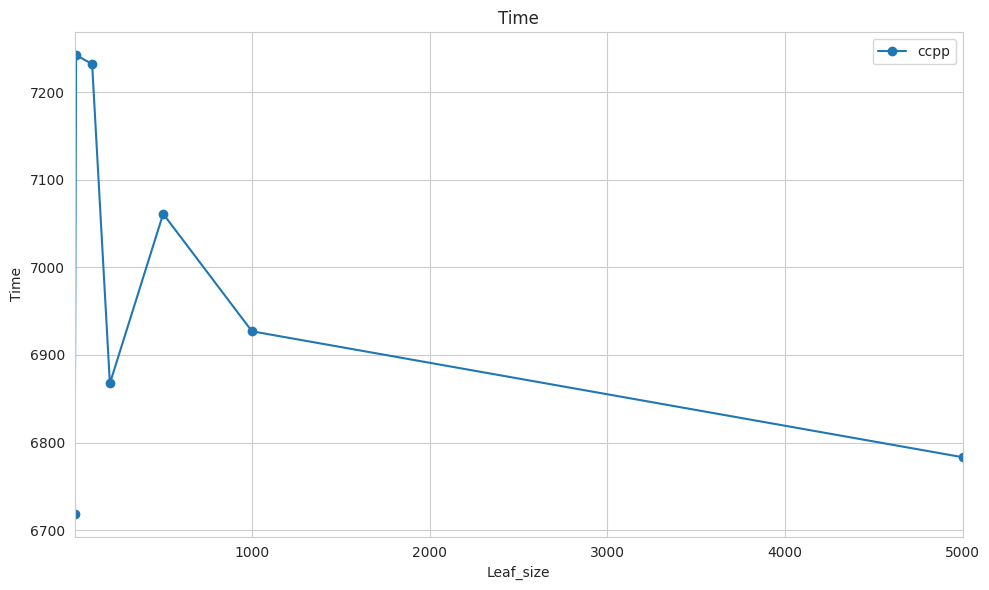

In [108]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    #'leaf_size': 30
}
hyperparameters_iterator = {'leaf_size': [1, 10, 100, 200, 500, 1000, 5000]}
knn_leaf_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_leaf_ccpp}, x_axis='leaf_size', y_axis=['time'], logaritmic=False)

In [102]:
### algorithm

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 10}
Hyperparameter  algorithm  value:  brute
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  algorithm  value:  kd_tree
R2:  0.952596495260365
MSE:  13.749764825496353


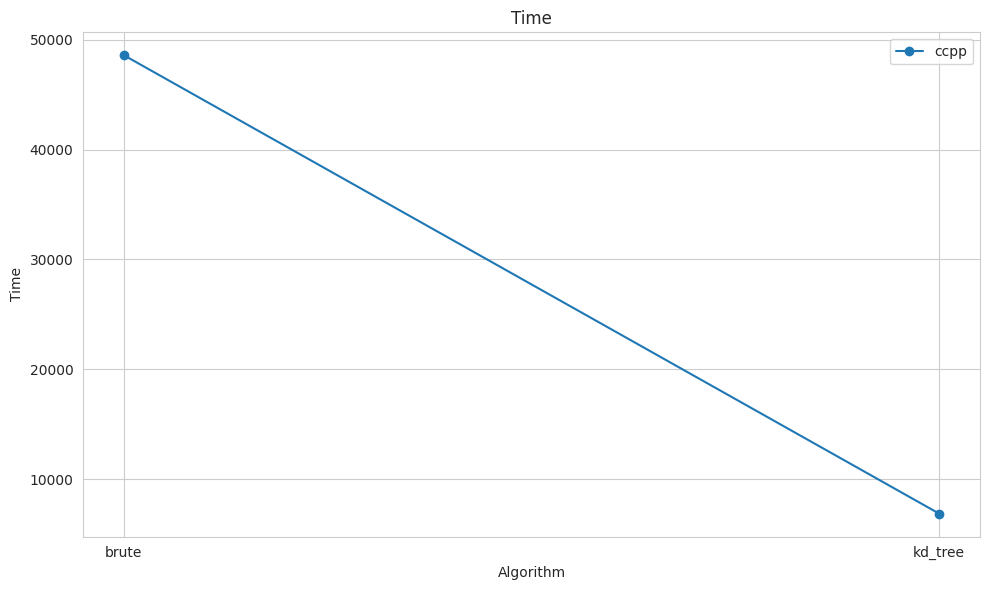

In [103]:
hyperparameters = {
    'n_neighbors': 5,
    #'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 10
}
hyperparameters_iterator = {'algorithm': ['brute', 'kd_tree']}
knn_metric_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_metric_ccpp}, x_axis='algorithm', y_axis=['time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 10}
Hyperparameter  algorithm  value:  brute
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  algorithm  value:  kd_tree
R2:  0.5059790010704448
MSE:  0.10234812834224584


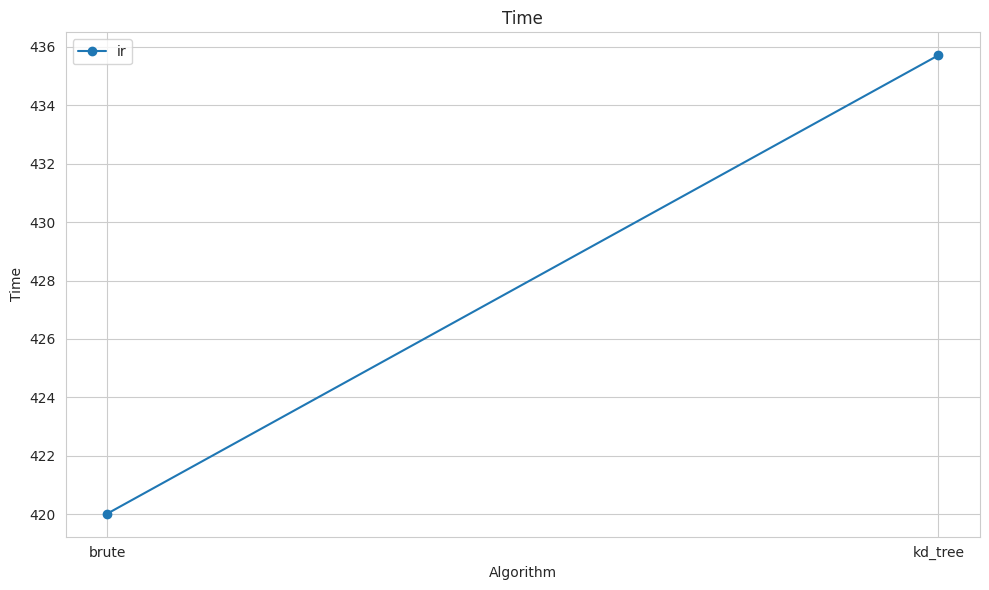

In [104]:
hyperparameters = {
    'n_neighbors': 5,
    #'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 10
}
hyperparameters_iterator = {'algorithm': ['brute', 'kd_tree']}
knn_metric_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_metric_ir}, x_axis='algorithm', y_axis=['time'], logaritmic=False)

In [105]:
### sklearn vs custom

In [106]:
from sklearn.neighbors import KNeighborsRegressor
import time

# measure time of custom knn kd_tree
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()   
ccpp_custom_time_kd = end - start

# measure time of custom knn brute
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_custom_time_brute = end - start

# measure time of sklearn knn kd_tree
knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_sklearn_time_kd = end - start

# measure time of sklearn knn brute
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_sklearn_time_brute = end - start

# same for ir
# measure time of custom knn kd_tree
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()   
ir_custom_time_kd = end - start

# measure time of custom knn brute
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_custom_time_brute = end - start

# measure time of sklearn knn kd_tree
knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_sklearn_time_kd = end - start

# measure time of sklearn knn brute
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_sklearn_time_brute = end - start

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


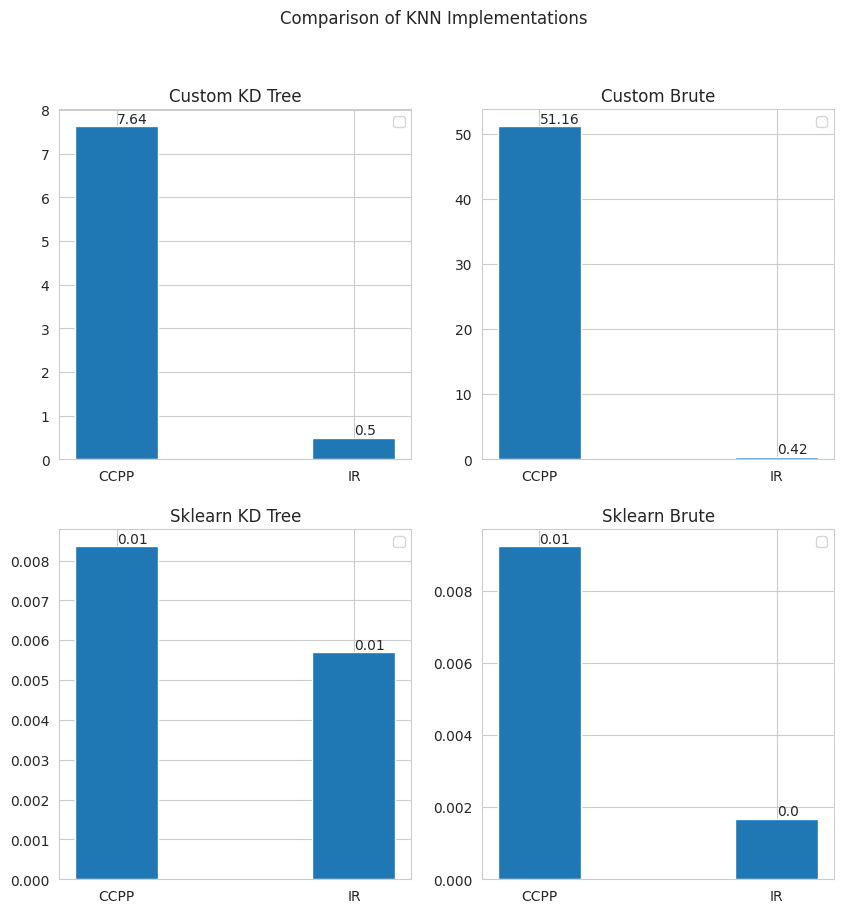

In [107]:

# draw a bar diagram
# group (ccpp_custom_time_kd, ir_custom_time_kd), (ccpp_custom_time_brute, ir_custom_time_brute), (ccpp_sklearn_time_kd, ir_sklearn_time_kd), (ccpp_sklearn_time_brute, ir_sklearn_time_brute)

import matplotlib.pyplot as plt
import numpy as np

# Define the data
group1 = [ccpp_custom_time_kd, ir_custom_time_kd]
group2 = [ccpp_custom_time_brute, ir_custom_time_brute]
group3 = [ccpp_sklearn_time_kd, ir_sklearn_time_kd]
group4 = [ccpp_sklearn_time_brute, ir_sklearn_time_brute]

# Create figure and 4 subplots with a larger size
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Define bar width and positions
bar_width = 0.35
x = np.arange(len(group1))

# Create bars for each subplot and add the values on top of the bars
for i, group in enumerate([group1, group2, group3, group4]):
    ax = axs[i//2, i%2]
    bars = ax.bar(x, group, width=bar_width)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Set x-ticks to be the middle of the groups of bars
for ax in axs.flat:
    ax.set_xticks(x)
    ax.set_xticklabels(['CCPP', 'IR'])
    ax.legend()

# Add labels and title for each subplot
axs[0, 0].set_title('Custom KD Tree')
axs[0, 1].set_title('Custom Brute')
axs[1, 0].set_title('Sklearn KD Tree')
axs[1, 1].set_title('Sklearn Brute')

# Add a global title
fig.suptitle('Comparison of KNN Implementations')

# Show the plot
plt.show()



## gradient

# datasets

In [ ]:
## Decision Tree Regressor

In [ ]:
## Gradient Descent

In [ ]:
## KNN

In [ ]:
## Infrared Thermo Temperature
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)
## Black Friday
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)
## Power Plant
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)

In [ ]:
## Gradient Descent Evaluation

In [ ]:
### Learning rate
reload(evaluator)

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

max_iter = 1000
alpha = 0.0001

my_gd_regressor = MyGDRegressor(max_iter=max_iter, alpha=alpha)

hyperparameters = {
    #'max_iter': 1000,
    'alpha': 0.001,
}
hyperparameters_iterator = {'max_iter': range(100, 10000, 250)}

ir_aplha_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                               ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                               hyperparameters=hyperparameters,
                                               hyperparameters_iterate=hyperparameters_iterator)

#evaluator.draw_diagram2_list({"gradient": ir_aplha_my_sg_regressor}, x_axis='learning_rate', y_axis=['r2', 'time'], logaritmic=False)

In [ ]:
### Max Iterations

In [ ]:
### Runtime comparison

In [ ]:
### Best run comparison

In [ ]:
# ir_X_train, ir_X_test, ir_y_train, ir_y_test

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

max_iter = 1000
alpha = 0.0001

sgd_regressor = SGDRegressor(max_iter=max_iter, alpha=alpha, eta0=alpha,
                             loss='squared_error',
                             learning_rate='constant', tol=None,
                             shuffle=False,
                             penalty=None
                             )
sgd_regressor.fit(ir_X_train, ir_y_train)
sgd_y_pred = sgd_regressor.predict(ir_X_test)

my_gd_regressor = MyGDRegressor(max_iter=max_iter, alpha=alpha)
my_gd_regressor.fit(ir_X_train, ir_y_train)
my_y_pred = my_gd_regressor.predict(ir_X_test)

# Calc mean squared error for evaluation
sgd_mse = mean_squared_error(ir_y_test, sgd_y_pred)
my_mse = mean_squared_error(ir_y_test, my_y_pred)
print("sklearn sgd regressor: ", sgd_mse)
print("my regressor: ", my_mse)